# Init

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder \
     .appName("Test") \
     .getOrCreate()

In [2]:
import pandas as pd
pd.options.display.max_rows=250
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter, FuncFormatter

import pyspark.sql.functions as func

# Dataset Imports

In [3]:
start = datetime.now()

df_mentions = spark.read.parquet("s3://labadie-gdelt-tradewar/mentions.parquet")
df_mentions.cache()

print(df_mentions.count())
print(df_mentions.printSchema())
print(datetime.now()-start)

329962831
root
 |-- EventDate: string (nullable = true)
 |-- MentionSource: string (nullable = true)
 |-- MentionIdentifier: string (nullable = true)
 |-- MentionDocTone: string (nullable = true)

None
0:02:42.976054


In [4]:
df_mentions.show()

+---------+--------------------+--------------------+-----------------+
|EventDate|       MentionSource|   MentionIdentifier|   MentionDocTone|
+---------+--------------------+--------------------+-----------------+
| 20170204|            wjsu.org|/post/supreme-cou...|-2.22929936305733|
| 20170306|    bostonherald.com|/news/us_politics...|-2.00752823086575|
| 20170306|              wam.ae|/en/details/13953...| 5.48780487804878|
| 20170306|              al.com|/news/index.ssf/2...|-3.03951367781155|
| 20170306|   therightscoop.com|/watch-live-now-t...| -2.6369168356998|
| 20170306|          iheart.com|powertalk1360./ar...|-1.45985401459854|
| 20170306|      irishtimes.com|/news/ireland/iri...|-2.45022970903522|
| 20170306|    naija247news.com|/2017/03/06/trump...|-2.10420841683367|
| 20170306|  vietnamtribune.com|/index.php/sid/25...|-6.11111111111111|
| 20170306| channelnewsasia.com|/news/world/old-e...|-5.52407932011331|
| 20170306|business-standard...|/article/news-ian...|-5.15021459

# Basic Plots

### Plotting functions

In [10]:
def plot_line_over_time(x,y_dict,y_axis_label,filename):
    fig, ax = plt.subplots(figsize=(10,5))

    data_to_plot = list(y_dict.items())
    
    # first set of data
    ax.plot(x,data_to_plot[0][1],label=data_to_plot[0][0])
    ax.set_xlabel("Week of Year")
    ax.tick_params(axis="x", rotation=30)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
    ax.set_ylabel(y_axis_label)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

    plt.legend()
    plt.tight_layout()
    plt.savefig("Plots/"+filename+".png", 
                facecolor=fig.get_facecolor(), 
                edgecolor='none')
    
    
def plot_line_over_time_two_y_axis(x,y_dict,filename):
    fig, ax = plt.subplots(figsize=(10,5))

    data_to_plot = list(y_dict.items())
    
    # first set of data
    ax.plot(x,data_to_plot[0][1],label=data_to_plot[0][0])
    ax.set_xlabel("Week of Year")
    ax.tick_params(axis="x", rotation=30)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
    ax.set_ylabel(data_to_plot[0][0])
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    
    if len(data_to_plot) > 1:
        for i in range(1,len(data_to_plot)):
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ax2.xaxis.set_major_locator(ticker.MultipleLocator(4))
            ax2.set_ylabel(data_to_plot[i][0])
            ax2.plot(x,data_to_plot[i][1],data_to_plot[i][1])      

    plt.tight_layout()
    plt.savefig("Plots/"+filename+".png", 
                facecolor=fig.get_facecolor(), 
                edgecolor='none')
    
    
def counts_by_week_year(relevant_events):
    # group by day
    all_events_by_day = pd.DataFrame(relevant_events.groupby("EventDate").count().collect())
    all_events_by_day.columns = ["Date","Count"]
    all_events_by_day["Date"] = pd.to_datetime(all_events_by_day["Date"].astype(str), format='%Y%m%d', errors="coerce")
    all_events_by_day = all_events_by_day[all_events_by_day["Date"] >= datetime.strptime("2015-04-01","%Y-%m-%d")]
    all_events_by_day = all_events_by_day.sort_values(by="Date")

    # get week number of year
    all_events_by_day["Week"] = ((all_events_by_day["Date"].dt.dayofyear-1)//7+1).apply(lambda x: '{0:0>2}'.format(min(x,52)))
    all_events_by_day["Year"] = all_events_by_day["Date"].dt.year.astype(str)
    all_events_by_day["YearWeek"] = all_events_by_day["Year"] + "-" + all_events_by_day["Week"]
    all_events_by_day = all_events_by_day.groupby(by="YearWeek")["Count"].sum().reset_index()

    return all_events_by_day


def avg_tone_by_week_year(relevant_events):
    all_events_by_day = pd.DataFrame(relevant_events.groupby("EventDate").agg(func.mean("MentionDocTone").alias("MentionDocTone")).collect())
    all_events_by_day.columns = ["Date","MentionDocTone"]
    all_events_by_day["Date"] = pd.to_datetime(all_events_by_day["Date"].astype(str), format='%Y%m%d', errors="coerce")
    all_events_by_day = all_events_by_day[all_events_by_day["Date"] >= datetime.strptime("2015-04-01","%Y-%m-%d")]
    all_events_by_day = all_events_by_day.sort_values(by="Date")

    # get week number of year
    all_events_by_day["Week"] = ((all_events_by_day["Date"].dt.dayofyear-1)//7+1).apply(lambda x: '{0:0>2}'.format(min(x,52)))
    all_events_by_day["Year"] = all_events_by_day["Date"].dt.year.astype(str)
    all_events_by_day["YearWeek"] = all_events_by_day["Year"] + "-" + all_events_by_day["Week"]
    all_events_by_day = all_events_by_day.groupby(by="YearWeek")["MentionDocTone"].mean().reset_index()

    return all_events_by_day


### Plot Count of All Events by Day

0:00:04.597310


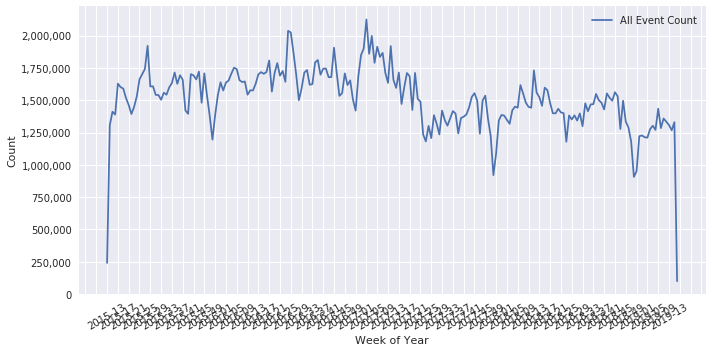

In [17]:
start = datetime.now()

# group by week_year
data = counts_by_week_year(df_mentions)

# group by week and plot
x=data["YearWeek"]
y_dict = {}
y_dict["All Event Count"] = data["Count"]
plot_line_over_time(x,y_dict,"Count","All_Events_Counts")

print(datetime.now()-start)

### Plot trump mentions

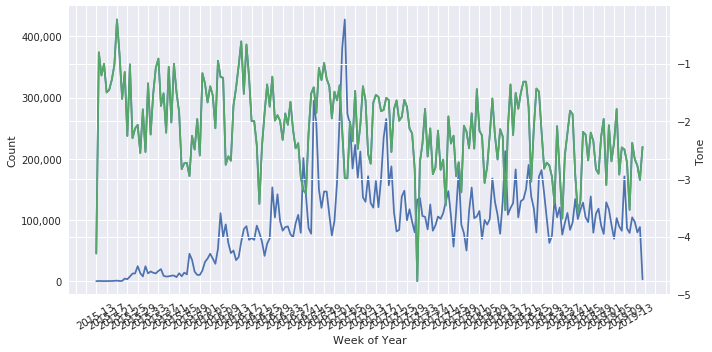

In [14]:
# get relevant events
relevant_events = df_mentions.where(df_mentions.MentionIdentifier.rlike('trump'))

# group by week_year
counts = counts_by_week_year(relevant_events)
tone = avg_tone_by_week_year(relevant_events)

# plot
x=counts["YearWeek"]
y_dict = {}
y_dict["Count"] = counts["Count"]
y_dict["Tone"]=tone["MentionDocTone"]

plot_line_over_time_two_y_axis(x,y_dict,"Trump_Events_Counts")

### Plot tariff mentions

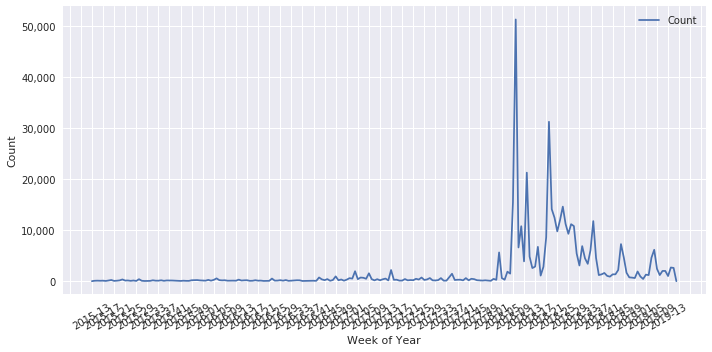

In [16]:
# get relevant events
relevant_events = df_mentions.where(df_mentions.MentionIdentifier.rlike('tariff')
                                  | df_mentions.MentionIdentifier.rlike('trade*war'))

# group by week_year
data = counts_by_week_year(relevant_events)

# group by week and plot
x=data["YearWeek"]
y_dict = {}
y_dict["Count"] = data["Count"]
plot_line_over_time(x,y_dict,"Count","Tariff_Events_Counts")

# EDA Across Fields
We could show how many countries are represented by the dataset.  Might just be interesting to show the breadth of the data.